In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

import os
import sys

notebook_dir = os.getcwd()  

emotions_dir   = os.path.abspath(os.path.join(notebook_dir, "..", "..", "emotions"))

evaluation_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

for d in (emotions_dir, evaluation_dir):
    if d not in sys.path:
        sys.path.insert(0, d)

from emotions import emotions_labels
from utils import predict_one, load_similarity_matrix, plot_confusion, predict_two, align_predictions_with_labels

/home/bryan/miniconda3/envs/env_nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_STORAGE_PATH = "sentiment_results"
CSV_PROMPTS_PATH = "eval_prompts.csv"
CSV_LYRICS_LABELS_PATH = "eval_lyrics_labels.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

## Hard evaluation

                                                text       label        pred
0  Your dedication to volunteering is truly inspi...  admiration  admiration
1  That joke about the cat wearing a tie made me ...   amusement   amusement
2  I can't believe you deleted all my work withou...       anger    surprise
3  That drill noise at seven in the morning again...   annoyance   annoyance
4      Great job, that refactor turned out flawless.    approval  admiration
Hard accuracy : 0.642


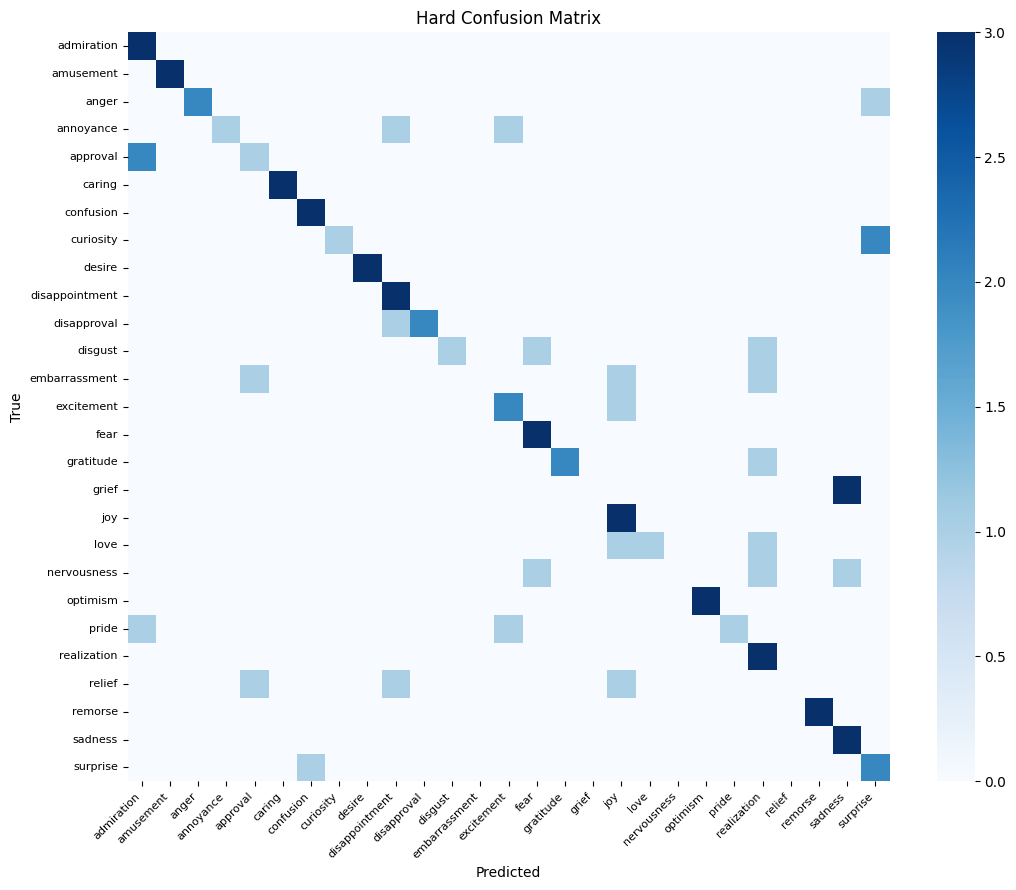

In [3]:
df = pd.read_csv(CSV_PROMPTS_PATH)
df["pred"] = df["text"].apply(predict_one)
print(df.head())
y_true = df["label"].values
y_pred = df["pred"].values
hard_acc = accuracy_score(y_true, y_pred)
hard_cm  = confusion_matrix(y_true, y_pred, labels=emotions_labels)

print(f"Hard accuracy : {hard_acc:.3f}")
plot_confusion(hard_cm, emotions_labels,
                title="Hard Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_hard.png"),
                vmax=hard_cm.max())

In [4]:
report = classification_report(df["label"], df["pred"], digits=3, zero_division=0)
report_path = os.path.join(RESULTS_STORAGE_PATH, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"Classification report saved to {report_path}")
print("report:")
print(report)

Classification report saved to sentiment_results\classification_report.txt
report:
                precision    recall  f1-score   support

    admiration      0.500     1.000     0.667         3
     amusement      1.000     1.000     1.000         3
         anger      1.000     0.667     0.800         3
     annoyance      1.000     0.333     0.500         3
      approval      0.333     0.333     0.333         3
        caring      1.000     1.000     1.000         3
     confusion      0.750     1.000     0.857         3
     curiosity      1.000     0.333     0.500         3
        desire      1.000     1.000     1.000         3
disappointment      0.500     1.000     0.667         3
   disapproval      1.000     0.667     0.800         3
       disgust      1.000     0.333     0.500         3
 embarrassment      0.000     0.000     0.000         3
    excitement      0.500     0.667     0.571         3
          fear      0.600     1.000     0.750         3
     gratitude      

## Soft evaluation

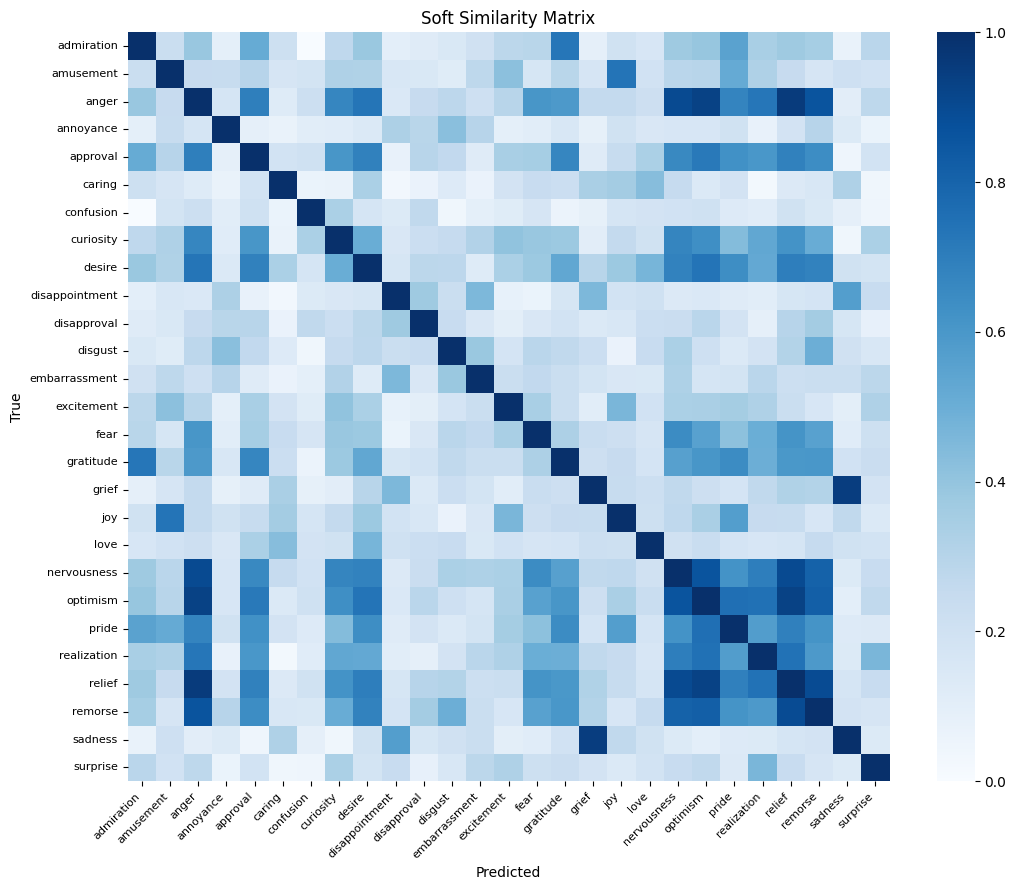

Soft accuracy : 0.784


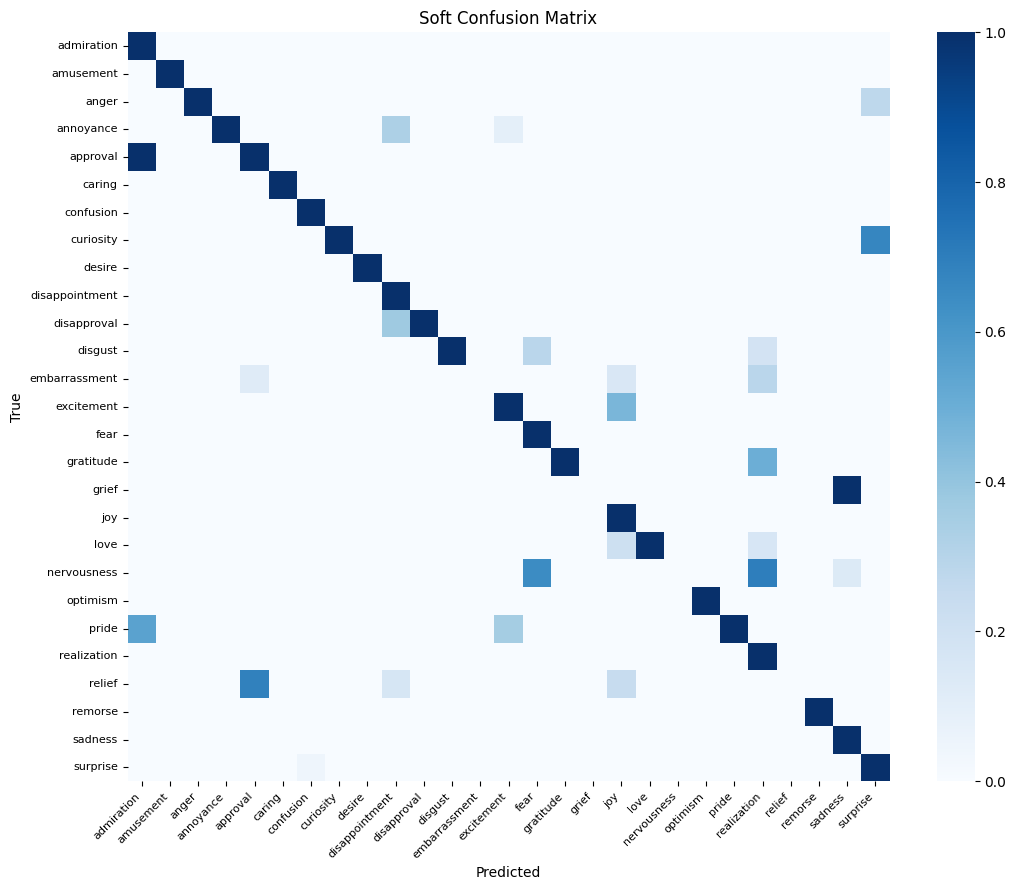

In [5]:
S = load_similarity_matrix()
plot_confusion(S, emotions_labels,
                title="Soft Similarity Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft_similarity.png"),
                vmax=S.max(), save=False)

soft_scores = [S[IDX[t], IDX[p]] for t, p in zip(y_true, y_pred)]
soft_acc    = np.mean(soft_scores)
print(f"Soft accuracy : {soft_acc:.3f}")
soft_cm = np.zeros_like(S)
for t, p in zip(y_true, y_pred):
    soft_cm[IDX[t], IDX[p]] += S[IDX[t], IDX[p]]

plot_confusion(soft_cm, emotions_labels,
                title="Soft Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft.png"), vmax=1.0)

df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "eval_prompts_with_preds.csv"), index=False)

## Etapa 2: Sentimientos de las canciones

In [ ]:
#Para elegir canciones aleatorias del Dataset Genius y tomar sus letras:

#df_songs = pd.read_csv("../../data/dataset_genius.csv")
#df_lyrics = df_songs[["lyrics"]]
# tomar 100 muestras aleatorias de df_lyrics
#df_lyrics_sample = df_lyrics.sample(n=100, random_state=42)
#df_lyrics_sample.to_csv("lyrics_sample.csv", index=True)

In [3]:
df = pd.read_csv("eval_lyrics_labels.csv")
print(df.head())
print(df.columns)

                                               lyric          label1  \
0  you re wondering if i care about ya or if ther...            love   
1  the youth have been tricked into war because t...           anger   
2  it s never easy to see the sun when you re loc...         sadness   
3  what makes him stand and fight when he only wa...  disappointment   
4  if i be so inclined to climb up beside you wou...          desire   

           label2  
0          caring  
1     disapproval  
2  disappointment  
3         remorse  
4       confusion  
Index(['lyric', 'label1', 'label2'], dtype='object')


y_true_flat: ['caring', 'love', 'anger', 'disapproval', 'sadness', 'disappointment', 'disappointment', 'remorse', 'desire', 'confusion', 'love', 'relief', 'optimism', 'curiosity', 'anger', 'confusion', 'disappointment', 'pride', 'caring', 'relief']
y_pred_flat: ['caring', 'love', 'embarrassment', 'disappointment', 'sadness', 'approval', 'annoyance', 'confusion', 'annoyance', 'confusion', 'love', 'desire', 'approval', 'annoyance', 'annoyance', 'confusion', 'disappointment', 'realization', 'caring', 'approval']
Hard accuracy : 0.400


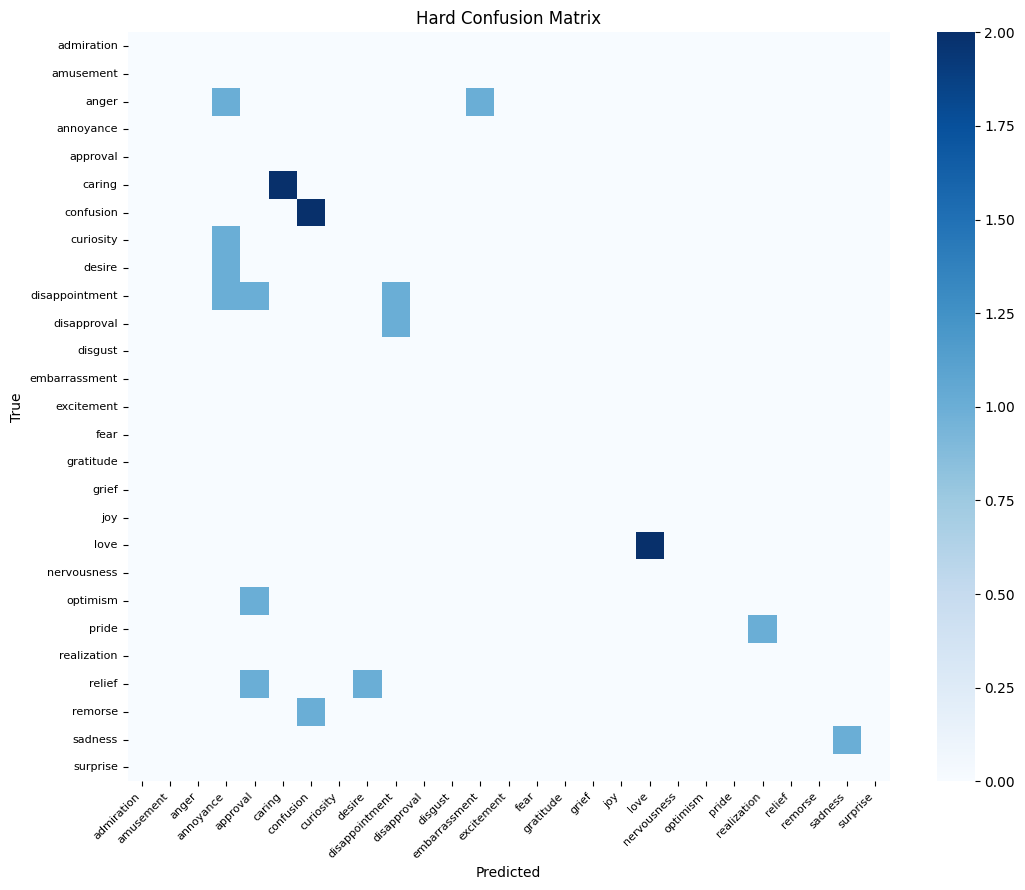

In [6]:
df = pd.read_csv(CSV_LYRICS_LABELS_PATH)
df["pred"] = df["lyric"].apply(predict_two)  # predict_two devuelve una lista de dos emociones


# Separar las etiquetas verdaderas
y_true_label1 = df["label1"].values
y_true_label2 = df["label2"].values

# Combinar las etiquetas verdaderas en pares
y_true = list(zip(y_true_label1, y_true_label2))  # Combinar las etiquetas en pares

y_pred = df["pred"].values 


# Reordenar las etiquetas verdaderas y predichas para que estén alineadas
aligned_pairs = [align_predictions_with_labels(pred, real) for pred, real in zip(y_pred, y_true)]

# Separar las predicciones y etiquetas reales alineadas
y_pred_aligned = [pair[0] for pair in aligned_pairs]
y_true_aligned = [pair[1] for pair in aligned_pairs]

# Aplanar las etiquetas después de reordenarlas
y_true_flat = [label for pair in y_true_aligned for label in pair]
y_pred_flat = [label for pair in y_pred_aligned for label in pair]

print(f"y_true_flat: {y_true_flat}")
print(f"y_pred_flat: {y_pred_flat}")

hard_acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"Hard accuracy : {hard_acc:.3f}")

# Generar matriz de confusión
hard_cm = confusion_matrix(y_true_flat, y_pred_flat, labels=emotions_labels)



plot_confusion(
    hard_cm, emotions_labels,
    title="Hard Confusion Matrix",
    fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_hard_acc.png"),
    vmax=hard_cm.max()
)

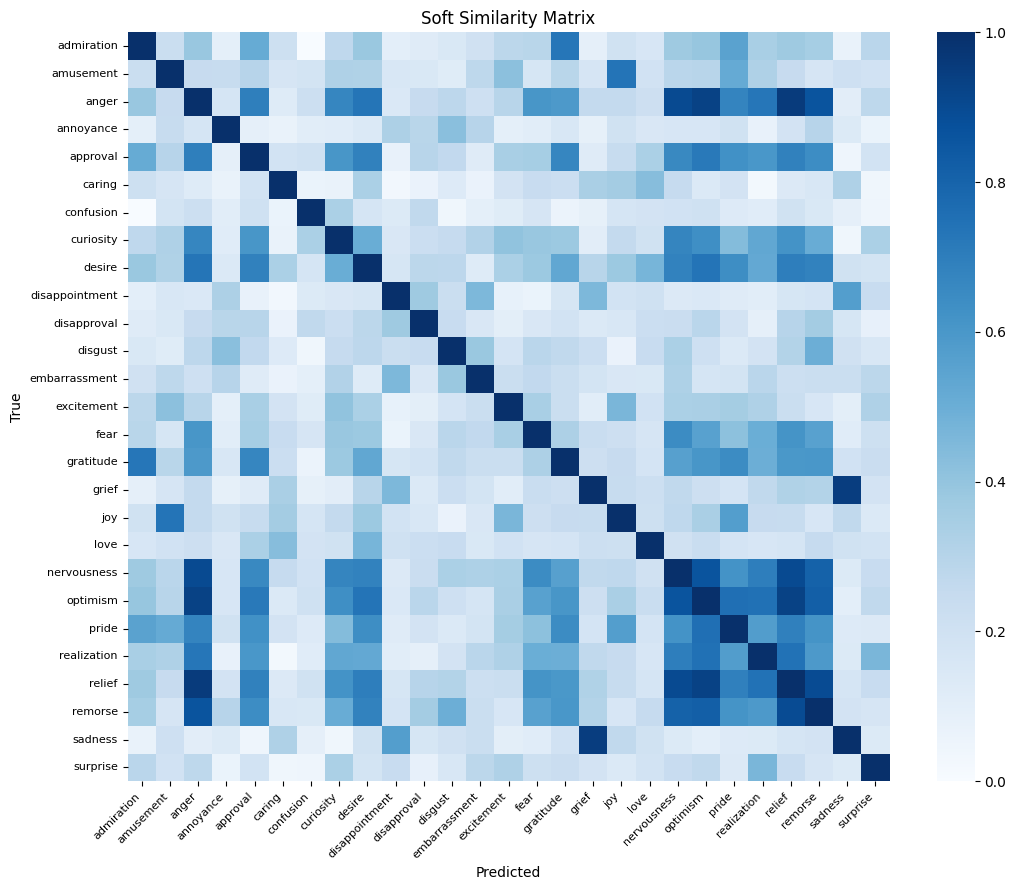

Soft accuracy : 0.613


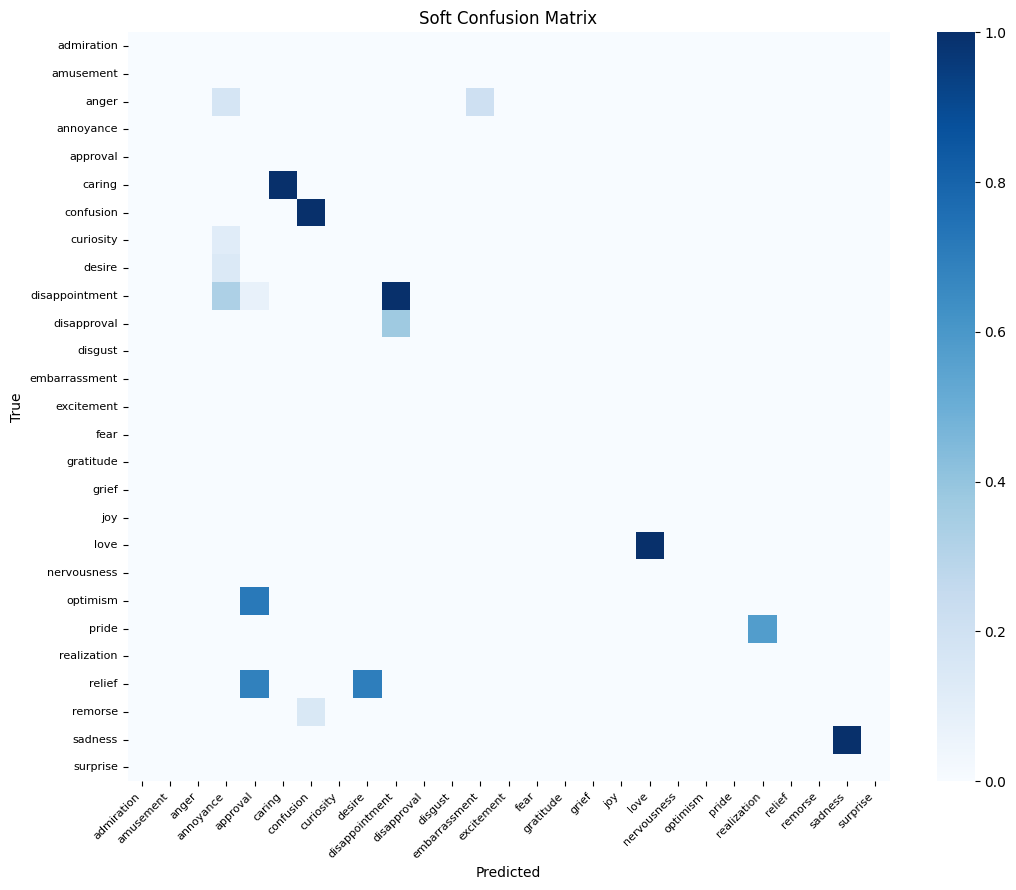

In [7]:
S = load_similarity_matrix()
plot_confusion(S, emotions_labels,
                title="Soft Similarity Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_soft_similarity.png"),
                vmax=S.max(), save=False)

soft_scores = [S[IDX[t], IDX[p]] for t_pair, p_pair in zip(y_true_aligned, y_pred_aligned) for t, p in zip(t_pair, p_pair)]
soft_acc  = np.mean(soft_scores)
print(f"Soft accuracy : {soft_acc:.3f}")
soft_cm = np.zeros_like(S)
for t_pair, p_pair in zip(y_true_aligned, y_pred_aligned):
    for t, p in zip(t_pair, p_pair):
        soft_cm[IDX[t], IDX[p]] += S[IDX[t], IDX[p]]

plot_confusion(soft_cm, emotions_labels,
                title="Soft Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_soft.png"), vmax=1.0)

# Guardar el DataFrame con las predicciones
df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "eval_prompts_with_preds.csv"), index=False)